Importing gempy



In [20]:
# Aux imports
import gempy as gp
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import glob
import random
from tqdm import tqdm
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing
from pyvista import set_plot_theme
np.random.seed(1515)
pd.set_option('precision', 2)
%matplotlib inline
set_plot_theme('document')

We import a model from an existing folder, representing a subduction
zone with onlap relationships. The theano function is automatically
recombined to allow changes.




In [34]:
#define grid dimentions: resolution, mesh_size, extentions
reso=[50, 50, 50]
mesh_size = reso[0]*reso[1]*reso[2]
extent=[0, 1588, 0, 1100, -1164, 50]
print(' mesh size: ' + str(mesh_size))

 mesh size: 125000


In [35]:
#introduce data and surface names to GemPy
geo_data = gp.create_data('foresets', extent=extent, resolution=reso,
                          path_o="2_orientation_data_all.csv",
                          path_i="1_point_data_all.csv")

gp.map_stack_to_surfaces(geo_data, {"Strat_Series1":('topo'),
                                    "Strat_Series2":('linglongbiotitegranite'),
                                    "Strat_Series3":('pyritesericitequartzalterationzone'),
                                    #"Fault_Series":('Jiaojia_fault'),
                                    "Strat_Series4":('sericitequartzalterationzone','Kfeldspathizationzone'),
                                    "Basement": ('basement')})

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,topo,Strat_Series1,1,#015482,1
1,linglongbiotitegranite,Strat_Series2,1,#9f0052,2
2,pyritesericitequartzalterationzone,Strat_Series3,1,#ffbe00,3
3,sericitequartzalterationzone,Strat_Series4,1,#728f02,4
4,Kfeldspathizationzone,Strat_Series4,2,#443988,5
5,basement,Basement,1,#ff3f20,6


In [36]:
#set geological structures and view the whole series
#geo_data.series.df['BottomRelation'][3]='Fault'
#geo_data.set_is_fault(['Fault_Series'])
geo_data.series

,order_series,BottomRelation,isActive,isFault,isFinite
Strat_Series1,1,Erosion,True,False,False
Strat_Series2,2,Erosion,True,False,False
Strat_Series3,3,Erosion,True,False,False
Strat_Series4,4,Erosion,True,False,False
Basement,5,Erosion,False,False,False


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


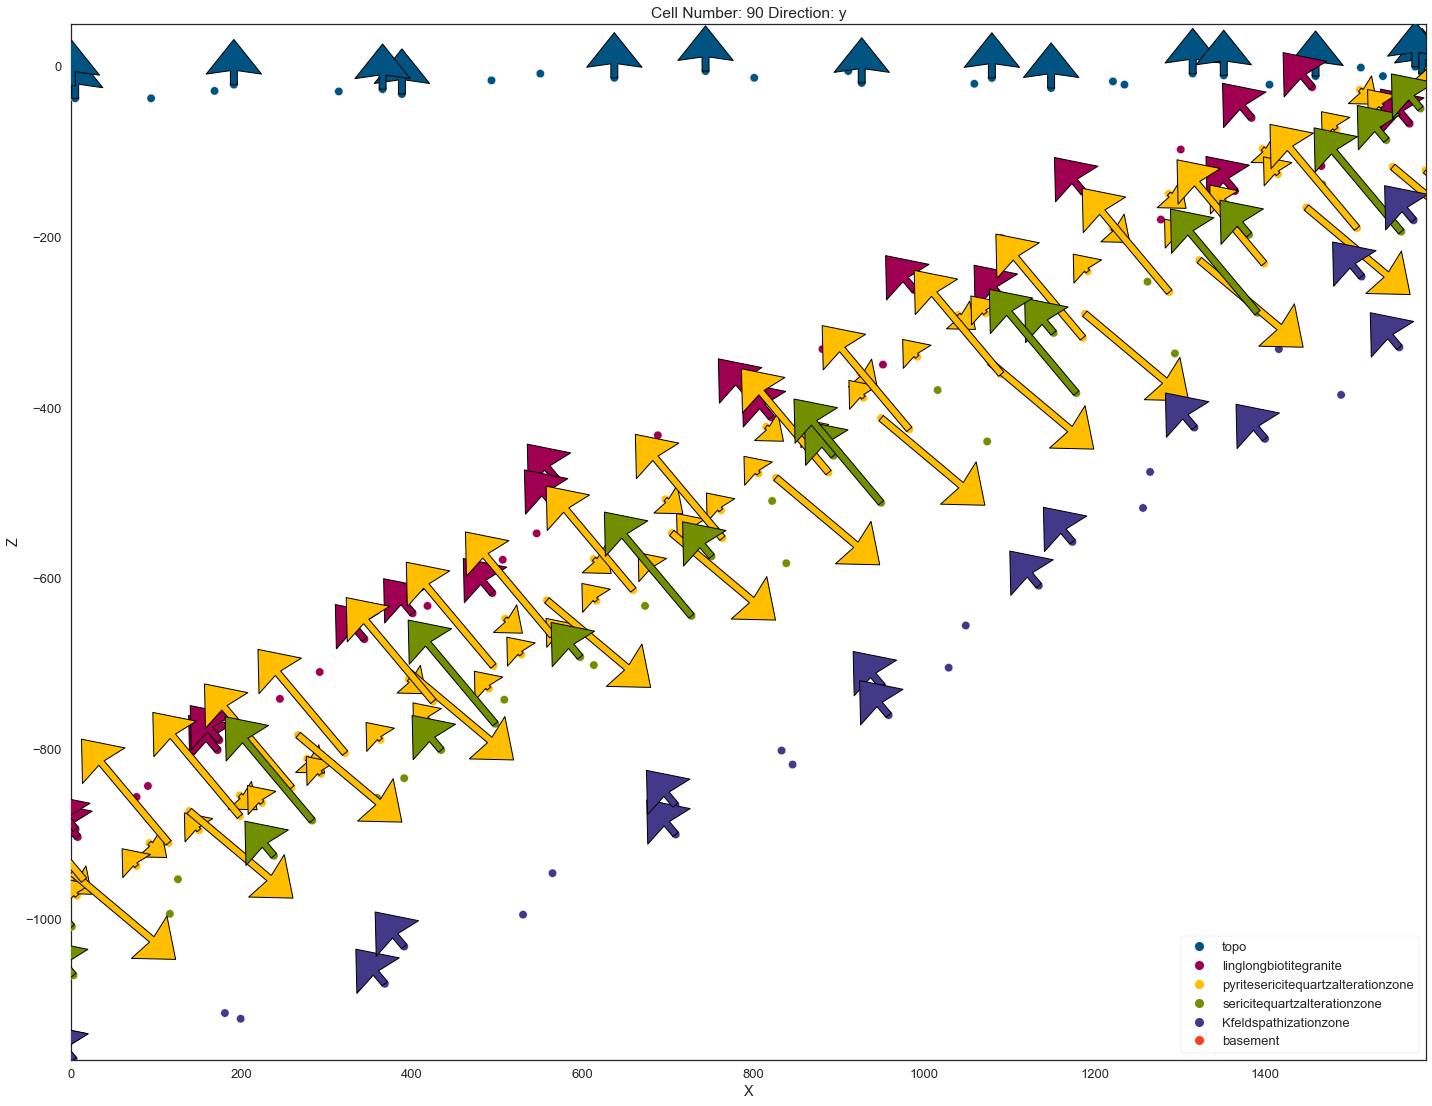

In [37]:
#plot cross section in desired 2D dimensions to view the data
gp.plot_2d(geo_data, cell_number=90, show_data=True, figsize=(20,20))

In [38]:
#create random topography surface for good visualization
geo_data.set_topography()

[-192.8   50. ]
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   15.88      ,    11.        , -1151.86      ],
       [   15.88      ,    11.        , -1127.58      ],
       [   15.88      ,    11.        , -1103.3       ],
       ...,
       [ 1588.        ,  1055.10204082,   -15.74282864],
       [ 1588.        ,  1077.55102041,   -25.13754273],
       [ 1588.        ,  1100.        ,   -23.12990354]])

In [39]:
#set gempy interpolator with theano compiler
interp_data = gp.set_interpolator(geo_data, compile_theano=True,theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                           values
range                    2281.57
$C_o$                  123941.43
drift equations  [3, 3, 3, 3, 3]


In [40]:
%%time
#computation of the model grid
sol = gp.compute_model(geo_data, compute_mesh=True, debug=False)

Wall time: 20 s


C:\Users\pasha\python\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


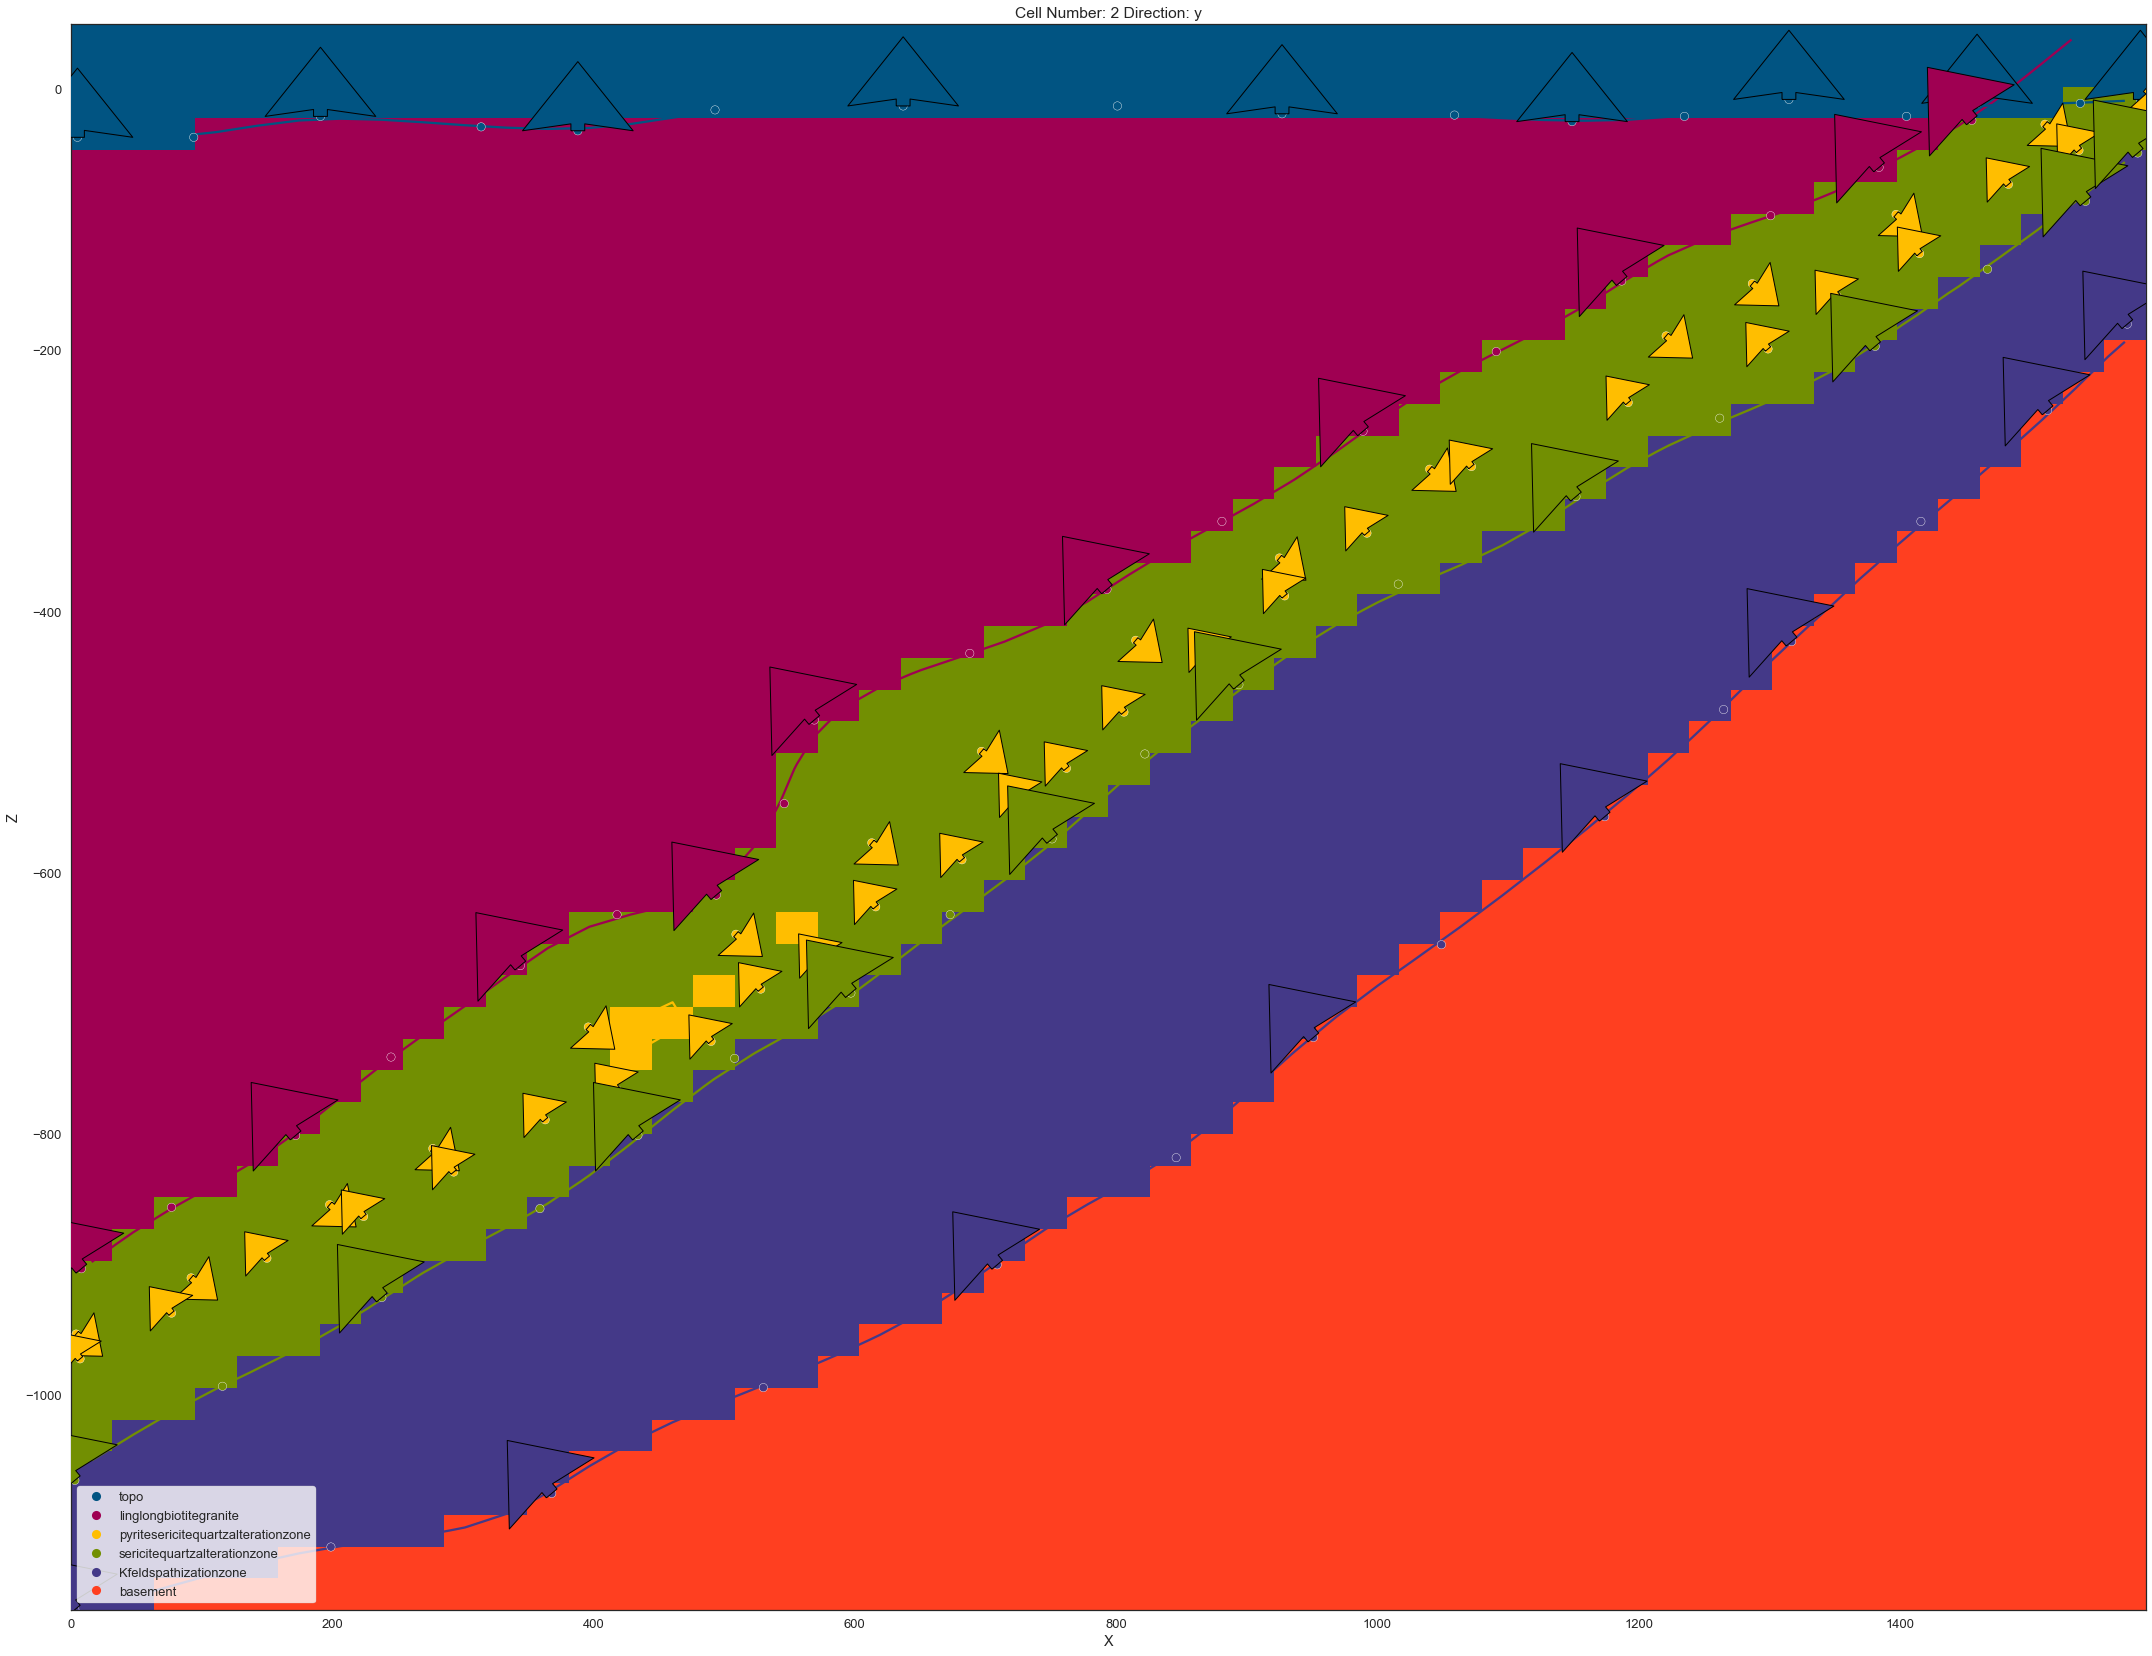

In [41]:
#plot cross section of the computed gempy model in a desired dimention and cell
gp.plot_2d(geo_data, direction='y', cell_number=2, show_data=True,  figsize=(30,30))

In [10]:
#plot 3D gempy model with background plotter; certain parameters can be enabled and changed in this line
p3d = gp.plot_3d(geo_data, plotter_type='background', show_lith=True, show_surfaces=True,  show_data=False, image=False,
                 show_topography=True,
                 kwargs_plot_structured_grid={'opacity': .5})

#save the 3D model data
gp.save_model(geo_data)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


True

In [42]:
#function written to extract computed gempy data with necessary location and unit information
def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    arguments:
        sol: Gempy solution object.
        unit: gempy unit by index
    returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # new version with rounding, definitely necessary
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, unit)

    # get coordinates by mask, mesh_size is defined on in[55]
    #krig_lith = sol.lith_block[mask]
    dom_grid = sol.grid.values[:mesh_size][mask]

    dom_x = dom_grid[:,0]
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z

In [43]:
#define the total domain amount, and series
unit_count=int(np.max(sol.lith_block.round(0)))
series_count=len(sol.scalar_field_matrix)
unit_count, series_count

(6, 4)

### Geostatistics and Kriging
the script below is designed to use two different mineral grading parameters and eventually visualize both in the same grid of the model

In [19]:
#load ore grade data for interpolation
df=pd.read_csv('kriging_data_all.csv')

# define kriging points coordinates and grade values
n=len(df.iloc[:,2])
x = df.iloc[:n,0]
y = df.iloc[:n,1]
z = df.iloc[:n,2]
cond_pos = np.array([x,y,z])

#introduce ore grade value
cond_val = df.iloc[:n,3]

#introduce cell location, create location array
domain_x, domain_y, domain_z = extract_domain(sol, (4))

# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)

In [20]:
%%time
#use ordinary kriging for estimation of ore grade distribution in a domain
model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=200)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)

# perform kriging
krige((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')

# just convenience rename
field= krige

# convert to pyvista mesh
pc = field.to_pyvista()

Wall time: 11.7 s


In [21]:
# inroducing kriged field for 3D plotting
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grade = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], 
                                        estimate=False).apply(pc)

#plot 3D model
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=False,
                kwargs_plot_structured_grid={'opacity': 1})

#add Ore grade map to 3D model mesh
gpv.p.add_mesh(grade, opacity=1, show_edges=False, lighting=False, cmap="terrain")

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000020263B942E0

In [30]:
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]
ore_interval2=[]
ore_dict={}
for index in tqdm(range(0, len(grade.active_scalars))):
    #for Cluster I:
    if 7.8>grade.active_scalars[index]>7.7:
        ore_interval1.append(grade.active_scalars[index])
        ore_dict.update({1: ore_interval1})
    #for Cluster II:
    elif 8.8>grade.active_scalars[index]>8.0:        
        ore_interval2.append(grade.active_scalars[index])
        ore_dict.update({2: ore_interval2})
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

for i in range(1,3):
    ore_avrg_grade=np.mean(ore_dict[i])
    volume=len(ore_dict[i])*(voxel_volume)
    print('Horizon1',volume)
    print("Average ore grade=", ore_avrg_grade)

100%|████████████████████████████████| 151868/151868 [01:15<00:00, 2002.36it/s]

Horizon1 65904961.1436
Average ore grade= 7.7641034052729045
Horizon1 8617505.4316
Average ore grade= 8.153463552186047


### Extract kriged data

In [ ]:
#extract already computed ore grade by Ordinary kriging 
main_array=pc.points.tolist()
added_array=grade.active_scalars.tolist()
n=len(main_array)

for index in range(0,n,1):
    main_array[index].append(added_array[index])
grade=pd.DataFrame(main_array, columns=['X','Y','Z','grade'])

In [ ]:
#drill boreholess!!
def krige_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(grade)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in grade.itertuples():
            if (grade.iloc[rand_ind[index]].X==row.X and grade.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.grade])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','grade']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict
 
#define the desired borehole amount and concat all the borehole data into one Pandas dataframe
boreholes=krige_boreholes(100)
drill_all = pd.concat(boreholes.values(), ignore_index=True)
drill_all

#save borehole data into csv file
drill_all.to_csv('3_kriging_100')

In [ ]:
vertices = drill_all[['X','Y','Z']].values
kriged=pv.PolyData(vertices)
kriged['grade'] = drill_all['grade'].values
kriged

In [ ]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(kriged, scalars='grade', opacity=1, cmap='viridis', point_size=5)

### Extract orientation data from the solution

In [44]:
#define the function to calculate gradient (dict_spec)

def get_gradient(sol, res, dim):
    '''
    Calculate gradient from model solution
    '''
    # scalar field as meshgrid
    dict_all={}
    dict_spec={}
    for index in range(0,series_count,1):
        scalar_mgrid = sol.scalar_field_matrix[index].reshape(res)

        # calculate gradient
        gx, gy, gz = np.gradient(scalar_mgrid)

       
        vectors = np.array([gx.reshape(int(res[0] ** dim)), gy.reshape(int(res[0] ** dim)), gz.reshape(int(res[0] ** dim))])
        vectors = np.swapaxes(vectors, 0, 1)
        vectors = preprocessing.normalize(vectors, norm='l2')
        dict_all.update({index:vectors})
         
    
    for index in range(0,series_count,1):
            data_temp = pd.DataFrame(dict_all[index])
            dict_spec.update({'series_{}'.format(index):data_temp})
    return dict_spec

dict_spec=get_gradient(sol, res=[50,50,50], dim=3)

#define cell locations and correspoding domain name
x=sol.grid.regular_grid.values[:, 0]
y=sol.grid.regular_grid.values[:, 1]
z=sol.grid.regular_grid.values[:, 2]
formation=sol.lith_block

#add cell locations and domain names to the gradient dataframe
for key,value in dict_spec.items():
    #load coordinate and formation array to the whole series dataframes
    value["X"]=x
    value['Y']=y
    value['Z']=z
    value['formation']=formation
    #value = value.reset_index()
    #define column names
    value.columns=['G_x','G_y','G_z','X','Y','Z','formation'] 

In [45]:
#extract and save necessary orientation data for each strat series
dict_spec['series_0']=dict_spec['series_0'][dict_spec['series_0'].formation==1]

dict_spec['series_1']=dict_spec['series_1'][dict_spec['series_1'].formation==2]

dict_spec['series_2']=dict_spec['series_2'][dict_spec['series_2'].formation==3]

dict_spec['series_3']=dict_spec['series_3'].drop(dict_spec['series_3'][(dict_spec['series_3'].formation<=3)].index)

#join all orientation data into one data frame; dropping orientation values for the Fault
orientations = pd.concat([dict_spec['series_0'],dict_spec['series_1'],dict_spec['series_2'], dict_spec['series_3']],
                         ignore_index=True)

#extract ideal case grid and define it as "ideal"
unit=range(0,unit_count+1)
for index in unit:
    domain_x, domain_y, domain_z = extract_domain(sol, (unit[index+1]))
    coordinates = np.array([domain_x, domain_y, domain_z])
    coordinates = coordinates.swapaxes(0,1)
    data=pd.DataFrame(coordinates, columns=['X','Y','Z'])
    data.loc[:, 'formation'] =float(unit[index+1])
    data.to_csv(r'data_extracted/ideal/unit_{}.csv'.format(unit[index+1]), mode="w", index=False)

IndexError: range object index out of range

In [46]:
# if you want to join all files in the same folder
path =r'data_extracted/ideal/'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
ideal = pd.concat(dfs, ignore_index=True)

#compare ideal and orientation grid and extract the cells that are the same
df_same = orientations.merge(ideal, left_on=('X','Y','Z','formation'), right_on=('X','Y','Z','formation'), how='inner')
df_same= df_same[df_same.formation != unit_count]
df_same

,G_x,G_y,G_z,X,Y,Z,formation
0,4.08e-02,4.05e-03,1.00,15.88,11.0,-34.98,1.0
1,-4.53e-03,-3.96e-03,1.00,15.88,11.0,13.58,1.0
2,-2.59e-02,-4.82e-03,1.00,15.88,11.0,37.86,1.0
3,2.54e-02,7.34e-04,1.00,15.88,33.0,-34.98,1.0
4,-1.04e-02,-6.25e-03,1.00,15.88,33.0,13.58,1.0
...,...,...,...,...,...,...,...
89779,-7.17e-01,9.17e-02,0.69,1572.12,1089.0,-229.22,5.0
89780,-7.03e-01,4.96e-02,0.71,1572.12,1089.0,-156.38,4.0
89781,-7.06e-01,4.03e-02,0.71,1572.12,1089.0,-132.10,4.0
89782,-7.10e-01,3.61e-02,0.70,1572.12,1089.0,-107.82,4.0


### Domain extraction, beginning of reverse modelling with extraction of wells

In [ ]:
#drill boreholess!!
def d_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(df_same)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in df_same.itertuples():
            if (df_same.iloc[rand_ind[index]].X==row.X and df_same.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.G_x, row.G_y, row.G_z, row.formation])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','G_x','G_y','G_z','formation']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict

#define desired number of boreholes
boreholes_dict=d_boreholes(100)

In [ ]:
#join all borehole data into one dataframe
df = pd.concat(boreholes_dict.values(), ignore_index=True)

#load joined csv dataset
bore_count = df['borehole'].nunique()

#create mesh grid and define vertices, convert it to a pyvista poly data
vertices = df[['X', 'Y', 'Z']].values
grid=pv.PolyData(vertices)
grid['formation'] = df['formation'].values

In [ ]:
unit=('topo','linglongbiotitegranite', 'pyritesericitequartzalterationzone','sericitequartzalterationzone',
      'Kfeldspathizationzone')
for index in range(0,unit_count):
    df['formation'] = df.loc[:,'formation'].replace(index,unit[index-1])
# boreholes[boreholes['formation']=='quartzite2'] - just for checking the dataset
df

In [ ]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(grid, scalars='formation', opacity=1, cmap='viridis', point_size=15)

### Extract data from boreholes to generate point data for the regenerated model

In [ ]:
#picking lowermost boundary for each formation through the borehole data 
dict_all=[]
list_temp=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,unit_count+1,1):
          list_temp.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for i in list_temp:
    if(not i.empty):
        list_temp2.append(i.iloc[0])
df_b=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_b['borehole']
df_b

In [ ]:
#in case of an intrusion, we can pick highest value of it to bound 
dict_all1=[]
list_temp1=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,unit_count+1,1):
          list_temp1.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for df in list_temp1:
    if(not df.empty):
        list_temp2.append(df.iloc[-1])
df_f=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_f['borehole']
df_f=df_f[df_f['formation']=='pyritesericitequartzalterationzone']
df_f

In [ ]:
joined=pd.concat([df_b,df_f])
#joined[joined['formation']=='pipe']

t = pd.CategoricalDtype(categories=['topo','linglongbiotitegranite', 'pyritesericitequartzalterationzone',
                                    'sericitequartzalterationzone','Kfeldspathizationzone'], ordered=True)
joined['formation']=pd.Series(joined.formation, dtype=t)
joined.sort_values(by=['formation'],inplace=True)
joined

In [ ]:
joined.to_csv(r'data_all_test100.csv', index = False)